
# 🏡 Project Portfolio Lab: Predicting House Prices (Multiple Linear Regression, Ridge & LASSO)

**Dataset:** `house_prices_portfolio.csv`    
**Goal:** Build and understand linear models to predict house prices.


## 🎯 Problem Statement
A real-estate analytics team wants to estimate **house prices** in a city using property and neighborhood features. Your task is to:
1. Explore the dataset and understand the relationships.
2. Build a **Multiple Linear Regression** model and interpret results.
3. Validate **assumptions** (linearity, independence, homoscedasticity, normality, multicollinearity, outliers).
4. Apply **variable selection** and **regularization** (Ridge/LASSO) to improve generalization.
5. **Persist** the best-performing model (save & load) for future use.

> This PPL mimics the workflow you'd follow in a real project and is perfect for your portfolio.


## ✅ What you'll learn
- Load and explore a dataset (EDA)  
- Build a **Multiple Linear Regression** model (`LinearRegression`)  
- Check basic assumptions with simple plots and tests  
- Understand **overfitting vs. generalization** (train vs. test performance)  
- Improve models with **Ridge (L2)** and **LASSO (L1)** regularization  
- **Save** and **load** a trained model using `pickle`  

In [ ]:

# === Setup ===
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, minmax_scale

# Inference & diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
# from statsmodels.stats.stattools import durbin_watson

# Persistence
import pickle
import joblib

# Utilities
import warnings
warnings.filterwarnings("ignore")


### 📦 Columns (quick reference)
- **House_Price** *(target, $1,000s)*  
- **Lot_Size, Bedrooms, Bathrooms, House_Age**  
- **Distance_to_CityCenter, Crime_Rate, Nearby_Schools**  
- **Monthly_Income, Renovated, Energy_Efficiency_Score**  
- **Garden_Size, Noise_Level**

### 🏠 House Prices Portfolio Data Dictionary

| **Column**                | **Type**             | **Notes**                                                                 |
|----------------------------|----------------------|--------------------------------------------------------------------------|
| **House_Price**            | float (1,000s)       | Target variable                                                          |
| **Lot_Size**               | int (m²)             | Land area; drives price; induces heteroscedasticity                      |
| **Bedrooms**               | int (count)          | More bedrooms generally increase price                                   |
| **Bathrooms**              | int (count)          | Correlated with bedrooms; affects price                                  |
| **House_Age**              | int (years)          | Older homes tend to be cheaper                                           |
| **Distance_to_CityCenter** | float (km)           | Further is cheaper on average                                            |
| **Crime_Rate**             | float (0–100 index)  | Higher crime lowers price                                                |
| **Nearby_Schools**         | int (count)          | More schools generally increase price                                    |
| **Monthly_Income**         | float ($)            | Large scale; correlated with energy score                                |
| **Renovated**              | int (0/1)            | Recently renovated boosts price                                          |
| **Energy_Efficiency_Score**| float (0–100)        | Correlated with income & renovation                                      |
| **Garden_Size**            | float (m²)           | Weak/low signal; useful for LASSO demonstration                          |
| **Noise_Level**            | float (0–10)         | Weak/low signal; inversely correlated with price; LASSO may drop         |


In [ ]:
# Load our data

In [2]:
df = pd.read_csv("house_prices_portfolio.csv")

df.head()

,House_Price,Lot_Size,Bedrooms,Bathrooms,House_Age,Distance_to_CityCenter,Crime_Rate,Nearby_Schools,Monthly_Income,Renovated,Energy_Efficiency_Score,Garden_Size,Noise_Level
0,89.96,2000,3,3,45,8.25,70.22,6,4158.35,0,56.29,125.1,8.38
1,9.92,1256,2,2,45,23.82,68.95,7,5658.32,1,80.23,136.6,3.99
2,175.77,2000,7,5,38,3.45,72.10,8,4652.73,0,60.33,375.4,8.45
3,57.77,2000,2,2,35,7.27,93.98,4,2381.04,0,44.46,308.8,8.45
4,74.11,913,3,3,7,8.87,89.90,6,2527.46,1,50.01,260.5,7.66


## Step 1: Quick EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   House_Price              500 non-null    float64
 1   Lot_Size                 500 non-null    int64  
 2   Bedrooms                 500 non-null    int64  
 3   Bathrooms                500 non-null    int64  
 4   House_Age                500 non-null    int64  
 5   Distance_to_CityCenter   500 non-null    float64
 6   Crime_Rate               500 non-null    float64
 7   Nearby_Schools           500 non-null    int64  
 8   Monthly_Income           500 non-null    float64
 9   Renovated                500 non-null    int64  
 10  Energy_Efficiency_Score  500 non-null    float64
 11  Garden_Size              500 non-null    float64
 12  Noise_Level              500 non-null    float64
dtypes: float64(7), int64(6)
memory usage: 50.9 KB


In [4]:
df.shape

(500, 13)

In [5]:
df.describe()

,House_Price,Lot_Size,Bedrooms,Bathrooms,House_Age,Distance_to_CityCenter,Crime_Rate,Nearby_Schools,Monthly_Income,Renovated,Energy_Efficiency_Score,Garden_Size,Noise_Level
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,98.989480,1690.904000,3.974000,3.060000,33.888000,8.942380,70.799160,6.670000,4514.206400,0.292000,61.379300,253.347200,8.217620
std,44.772335,342.192294,1.631763,1.584115,19.538346,5.910477,13.476801,2.105699,1492.544152,0.455138,12.059863,114.968455,1.529183
min,-41.290000,736.000000,1.000000,1.000000,0.000000,1.420000,25.320000,2.000000,1500.000000,0.000000,31.690000,14.000000,0.010000
25%,69.665000,1431.500000,3.000000,2.000000,17.000000,5.017500,61.790000,5.000000,3409.370000,0.000000,52.910000,159.875000,7.555000
50%,99.385000,1810.000000,4.000000,3.000000,34.000000,7.460000,71.085000,7.000000,4510.395000,0.000000,60.705000,245.950000,8.465000
75%,129.342500,2000.000000,5.000000,4.000000,50.000000,11.160000,81.185000,8.000000,5487.370000,1.000000,69.462500,335.850000,9.272500
max,334.620000,2000.000000,7.000000,6.000000,69.000000,40.000000,95.000000,14.000000,8767.940000,1.000000,96.990000,548.100000,10.000000


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
House_Price,500.0,98.98948,44.772335,-41.29,69.6650,99.385,129.3425,334.62
Lot_Size,500.0,1690.90400,342.192294,736.00,1431.5000,1810.000,2000.0000,2000.00
Bedrooms,500.0,3.97400,1.631763,1.00,3.0000,4.000,5.0000,7.00
Bathrooms,500.0,3.06000,1.584115,1.00,2.0000,3.000,4.0000,6.00
House_Age,500.0,33.88800,19.538346,0.00,17.0000,34.000,50.0000,69.00
Distance_to_CityCenter,500.0,8.94238,5.910477,1.42,5.0175,7.460,11.1600,40.00
Crime_Rate,500.0,70.79916,13.476801,25.32,61.7900,71.085,81.1850,95.00
Nearby_Schools,500.0,6.67000,2.105699,2.00,5.0000,7.000,8.0000,14.00
Monthly_Income,500.0,4514.20640,1492.544152,1500.00,3409.3700,4510.395,5487.3700,8767.94
Renovated,500.0,0.29200,0.455138,0.00,0.0000,0.000,1.0000,1.00


In [7]:
# Correlation

corr = df.corr()['House_Price'].sort_values()
corr

Crime_Rate                -0.490324
Distance_to_CityCenter    -0.409821
House_Age                 -0.272099
Renovated                  0.135616
Garden_Size                0.144462
Lot_Size                   0.179512
Noise_Level                0.325410
Energy_Efficiency_Score    0.350907
Monthly_Income             0.384082
Nearby_Schools             0.403098
Bathrooms                  0.492771
Bedrooms                   0.525954
House_Price                1.000000
Name: House_Price, dtype: float64

In [8]:
corr = df.corr()
corr

,House_Price,Lot_Size,Bedrooms,Bathrooms,House_Age,Distance_to_CityCenter,Crime_Rate,Nearby_Schools,Monthly_Income,Renovated,Energy_Efficiency_Score,Garden_Size,Noise_Level
House_Price,1.000000,0.179512,0.525954,0.492771,-0.272099,-0.409821,-0.490324,0.403098,0.384082,0.135616,0.350907,0.144462,0.325410
Lot_Size,0.179512,1.000000,0.063571,0.030610,0.053722,0.019590,0.056230,-0.080179,-0.051788,-0.017036,-0.065431,0.456832,-0.045337
Bedrooms,0.525954,0.063571,1.000000,0.884418,0.022977,0.007983,-0.069296,0.079151,0.076328,-0.011344,0.051116,0.033587,-0.029483
Bathrooms,0.492771,0.030610,0.884418,1.000000,0.021002,0.021335,-0.052858,0.058216,0.073688,-0.007671,0.048782,0.010777,-0.049570
House_Age,-0.272099,0.053722,0.022977,0.021002,1.000000,0.145725,0.077111,-0.050730,-0.039440,-0.024710,-0.044313,0.066894,-0.112119
Distance_to_CityCenter,-0.409821,0.019590,0.007983,0.021335,0.145725,1.000000,0.328818,-0.254790,0.011865,0.027551,0.001232,-0.024033,-0.883563
Crime_Rate,-0.490324,0.056230,-0.069296,-0.052858,0.077111,0.328818,1.000000,-0.755666,-0.868841,-0.306805,-0.757887,0.041200,-0.284605
Nearby_Schools,0.403098,-0.080179,0.079151,0.058216,-0.050730,-0.254790,-0.755666,1.000000,0.760641,0.295212,0.671172,-0.078793,0.232277
Monthly_Income,0.384082,-0.051788,0.076328,0.073688,-0.039440,0.011865,-0.868841,0.760641,1.000000,0.367611,0.865443,-0.076503,-0.009697
Renovated,0.135616,-0.017036,-0.011344,-0.007671,-0.024710,0.027551,-0.306805,0.295212,0.367611,1.000000,0.564241,0.018364,-0.035251


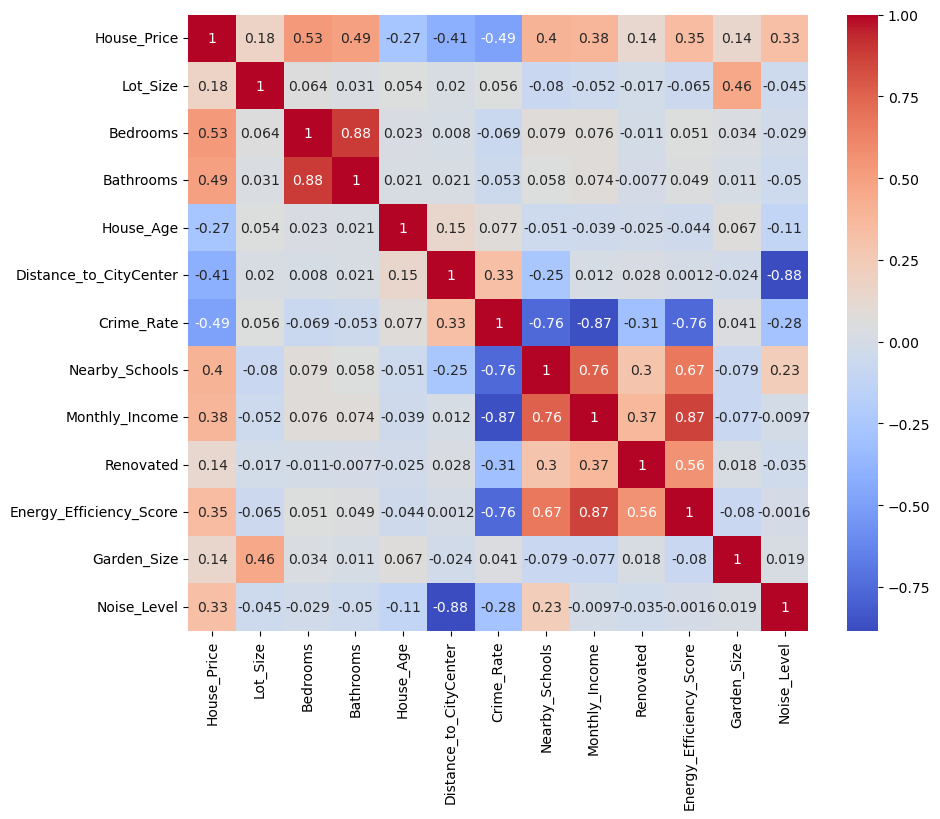

In [9]:
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [10]:
df.head(1)

,House_Price,Lot_Size,Bedrooms,Bathrooms,House_Age,Distance_to_CityCenter,Crime_Rate,Nearby_Schools,Monthly_Income,Renovated,Energy_Efficiency_Score,Garden_Size,Noise_Level
0,89.96,2000,3,3,45,8.25,70.22,6,4158.35,0,56.29,125.1,8.38


## Step 2: Train/Test Split

In [11]:
X = df.drop(columns=['House_Price'])
y = df['House_Price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(400, 12)

## Step 3: Baseline Multiple Linear Regression (sklearn == Scikit Learn)

In [14]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [15]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [16]:
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = root_mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In [17]:
print(f"Train MSE: {mse_train:.3f} | Test MSE: {mse_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train R2_Score: {r2_train:.3f} | Test R2_Score: {r2_test:.3f}")

Train MSE: 630.247 | Test MSE: 818.373
Train RMSE: 25.105 | Test RMSE: 28.607
Train R2_Score: 0.694 | Test R2_Score: 0.533


## Step 4: Inference, OLS with Statmodels (Coefficients, P-value)

In [18]:
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            House_Price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     73.03
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.50e-91
Time:                        23:59:04   Log-Likelihood:                -1856.8
No. Observations:                 400   AIC:                             3740.
Df Residuals:                     387   BIC:                             3791.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      42.3895     33.988      1.247      0.213     -24.435     109.214
Lot_Size                    0.0184      0.004      4.326      0.000       0.010       0.027
Bedrooms                    8.3121      1.707      4.870      0.000       4.956      11.668
Bathrooms                   5.8201      1.767      3.294      0.001       2.346       9.294
House_Age                  -0.5409      0.066     -8.168      0.000      -0.671      -0.411
Distance_to_CityCenter     -3.1276      0.516     -6.059      0.000      -4.143      -2.113
Crime_Rate                 -0.3959      0.268     -1.475      0.141      -0.924       0.132
Nearby_Schools              0.0559      1.029      0.054      0.957      -1.967       2.079
Monthly_Income              0.0033      0.003      1.121      0.263      -0.003       0.009
Renovated                  -2.2102      3.633     -0.608      0.543      -9.353       4.932
Energy_Efficiency_Score     0.6715      0.265      2.529      0.012       0.150       1.193
Garden_Size                 0.0442      0.013      3.490      0.001       0.019       0.069
Noise_Level                -2.2623      1.753     -1.290      0.198      -5.709       1.184
==============================================================================
Omnibus:                      104.577   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.206
Skew:                           0.924   Prob(JB):                    1.09e-151
Kurtosis:                       9.189   Cond. No.                     1.37e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Step 5: Test Basic Assumptions

- Linearity
- Normality
- Multicollinearity
- Homo/Heteroscedasticity

In [19]:
fitted = y_train_pred
residuals = y_train - fitted

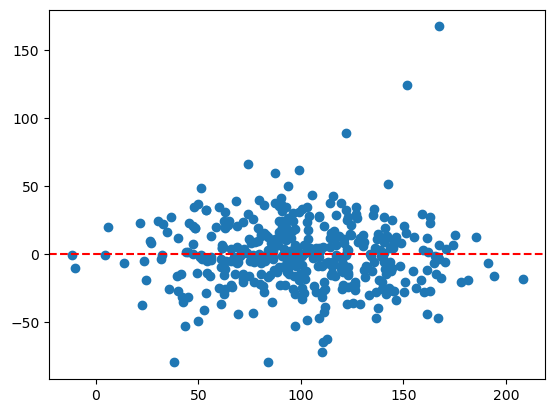

In [20]:
plt.scatter(fitted, residuals)
plt.axhline(0, linestyle='--', c='red')
plt.show()

# Step 6: Regularization (Ridge & LASSO)

In [21]:
# Scale
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Fit with RIdge and Lassor

ridge = Ridge(alpha=0.8, random_state=42)
lasso = Lasso(alpha=0.0001, random_state=42, max_iter=100000)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)


lasso_train_pred = lasso.predict(X_train_scaled)
lasso_test_pred = lasso.predict(X_test_scaled)

In [66]:
print("Lasso Train R2", r2_score(y_train, lasso_train_pred))
print("Lasso Test R2", r2_score(y_test, lasso_test_pred))

Lasso Train R2 0.6936659818816076
Lasso Test R2 0.5334738544083215


In [23]:
lasso_coefs = pd.Series(lasso.coef_, index=X_train.columns).sort_values()

lasso_coefs

Distance_to_CityCenter    -18.820791
House_Age                 -10.621666
Crime_Rate                 -5.468262
Noise_Level                -3.499901
Renovated                  -1.012565
Nearby_Schools              0.120119
Monthly_Income              4.997052
Garden_Size                 5.132048
Lot_Size                    6.341321
Energy_Efficiency_Score     8.007071
Bathrooms                   9.340824
Bedrooms                   13.821420
dtype: float64